# Semantle solving agent - similar cohorts Bayesian approach

Defines an agent that uses Bayesian comparison of multiple cohorts, where each cohort shares a similarity score with the target, to find the semantle target/secret word

In [1]:
from english_words import english_words_set
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import timeit

from semantle_simulator import SemantleSimulator
from similarity_model import SimilarityModelW2V, SimilarityModelUSE
import cohort_bayes_solver as cbs

## Simulator for semantle

In [2]:
sem_sim = SemantleSimulator()

In [3]:
sem_sim.target = 'terrible'

## Agent capabilities

Agent reuses semantle embedding space, but could potentially use a different semantic representation. Word list is closer (~30k) to what a human could potentially recall.

In [4]:
w2v_semantics = sem_sim.wv
base_vocabulary = english_words_set
if sem_sim.target not in base_vocabulary:
    base_vocabulary.add(sem_sim.target)
    
#similarity = SimilarityModelUSE(base_vocabulary)
similarity = SimilarityModelW2V(base_vocabulary, w2v_semantics)

## Run the solving agent

The agent makes sensible guesses and updates its belief about likely targets to guide further guesses.

In [5]:
solver = cbs.CohortBayesSolver(similarity, precision=0.1, recall=0.5, log=True)

In [6]:
%%time
target, steps = solver.solve(sem_sim)
print(f'semantle target "{sem_sim.target}"')
print(f'solver reached "{similarity.word_string(target)}" (id {target}) in {steps} steps')

semantle target "terrible"
solver reached "terrible" (id 10708) in 21 steps
CPU times: user 715 ms, sys: 924 ms, total: 1.64 s
Wall time: 2.42 s


## Visualise the results

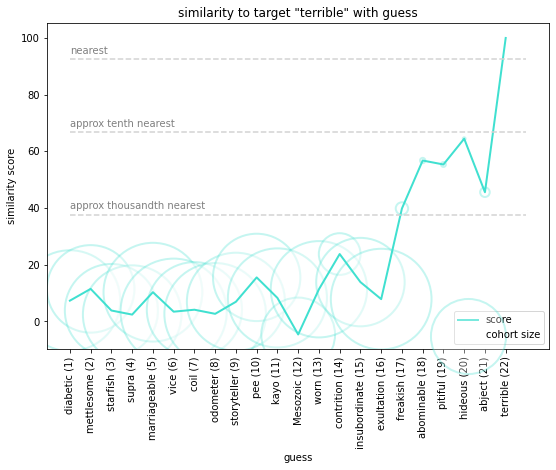

In [7]:
plt.figure(figsize=(9,6))
tgt_cal = sem_sim.score_calibration()
xs = range(len(solver.logging['guess']))
ys = [sem_sim.score_guess(similarity.word_string(g)) for g in solver.logging['guess']]
plt.plot(ys, color='turquoise', lw=2)
plt.scatter(xs, ys, s=solver.logging['cohort_size'], c='w', edgecolors='turquoise', alpha=0.3, lw=2)
plt.plot([0, len(ys)], [tgt_cal[0][1], tgt_cal[0][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[0][1] + 2, 'nearest', c='grey') 
plt.plot([0, len(ys)], [tgt_cal[1][1], tgt_cal[1][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[1][1] + 2, 'approx tenth nearest', c='grey') 
plt.plot([0, len(ys)], [tgt_cal[2][1], tgt_cal[2][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[2][1] + 2, 'approx thousandth nearest', c='grey') 
plt.title(f'similarity to target "{sem_sim.target}" with guess')
plt.ylabel('similarity score')
plt.xlabel('guess')
plt.legend(['score', 'cohort size'], loc='lower right')
xtick_lim = 46
xtick_step = max(1, int(round(len(ys) / xtick_lim)))
xticks = range(0, len(ys), xtick_step)
xtick_labels = [f'{similarity.word_string(solver.logging["guess"][xt])} ({xt + 1})' for xt in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
plt.show()

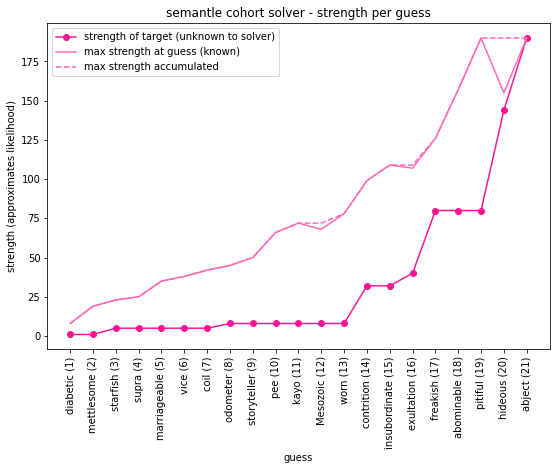

In [8]:
plt.figure(figsize=(9,6))
plt.plot(solver.logging['target_strength'], '-o', c='deeppink')
plt.plot(solver.logging['max_strength'], c='hotpink')
plt.plot(np.maximum.accumulate(solver.logging['max_strength']), '--', c='hotpink')
plt.title('semantle cohort solver - strength per guess')
plt.legend(['strength of target (unknown to solver)', 'max strength at guess (known)', 'max strength accumulated'])
plt.ylabel('strength (approximates likelihood)') 
plt.xlabel('guess')
xtick_lim = 30
xtick_step = max(1, steps // xtick_lim)
xticks = range(0, steps, xtick_step)
xtick_labels = [f'{similarity.word_string(solver.logging["guess"][xt])} ({xt + 1})' for xt in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
plt.show()

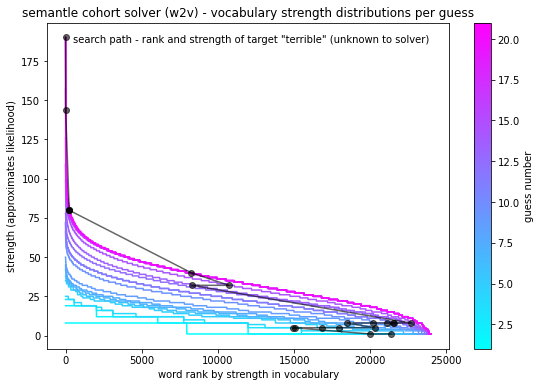

In [9]:
plt.figure(figsize=(9,6))
for i, s in enumerate(solver.logging['strength_history']):
    interp = i / len(solver.logging['strength_history'])
    plt.plot(list(reversed(sorted(s))), c=mpl.cm.cool(interp))
plt.plot(solver.logging['target_rank'], solver.logging['target_strength'], 'o-', c='k', alpha=0.6)
plt.text(500, np.max(solver.logging['strength_history']) - 3, f'search path - rank and strength of target "{sem_sim.target}" (unknown to solver)') 
plt.title(f'semantle cohort solver ({similarity.description}) - vocabulary strength distributions per guess')
plt.ylabel('strength (approximates likelihood)')
plt.xlabel('word rank by strength in vocabulary')
guess_norm = mpl.colors.Normalize(vmin=1, vmax=steps)
plt.colorbar(mpl.cm.ScalarMappable(norm=guess_norm, cmap=mpl.cm.cool), label='guess number')
plt.show()

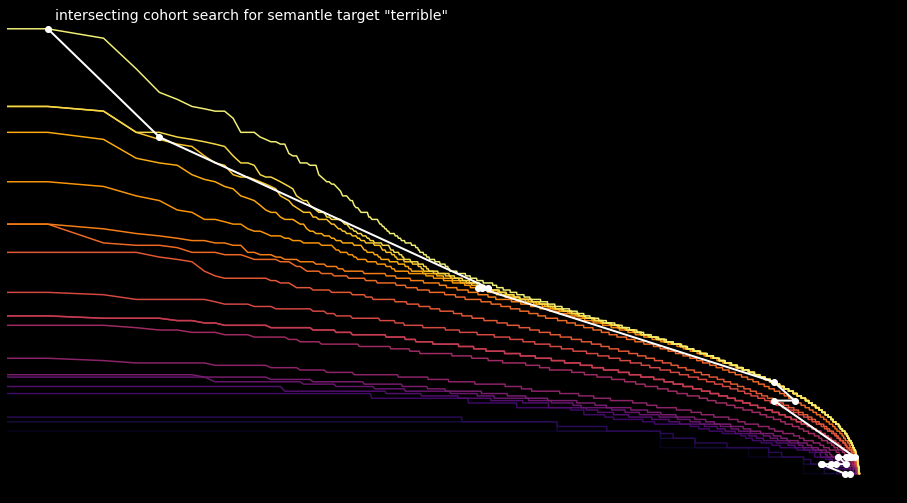

In [10]:
plt.figure(figsize=(16,9), facecolor='black')
for i, s in enumerate(solver.logging['strength_history']):
    interp = i / len(solver.logging['strength_history'])
    plt.plot(list(reversed(sorted(s))), c=mpl.cm.inferno(interp))
plt.plot(solver.logging['target_rank'], solver.logging['target_strength'], 'o-', lw=2, c='w')
plt.text(1.1, np.max(solver.logging['strength_history']) + 4,
         f'intersecting cohort search for semantle target "{sem_sim.target}"',
         size=14, c='w') 
plt.xscale('log')
plt.axis('off')
plt.show()